# Fraud Detection Team Data Detective

In [3]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/79/3d/02d5d3ed359498fec3abdf65407d3c07e3b8765af17464969055aaec5171/scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 217.9 kB/s eta 0:00:49
   ---------------------------------------- 0.0/10.6 MB 186.2 kB/s eta 0:00:57
   ---------------------------------------- 0.1/10.6 MB 297.7 kB/s eta 0:00:36
    --------------------------------------- 0.2/10.6 MB 654.6 kB/s eta 0:00:16
   - -------------------------------------- 0.3/10.6 MB 1.2 MB/s eta 0:00:09
   -- ------------------------------------- 0.6/10.6 MB 1.9 MB/s eta 0:00:06
   ---- ----------------------------------- 1.2/10.6 MB 3.1 MB/s eta 0:00:04
   ------ ---------------

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

from typing import List, Tuple

In [3]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

## Data File Objects

In [4]:
data = Path.cwd() / 'data' / 'fraud_detection'

ch1 = data / 'chapter_1'
cc1_file = ch1 / 'creditcard_sampledata.csv'
cc3_file = ch1 / 'creditcard_sampledata_3.csv'

ch2 = data / 'chapter_2'
cc2_file = ch2 / 'creditcard_sampledata_2.csv'

ch3 = data / 'chapter_3'
banksim_file = ch3 / 'banksim.csv'
banksim_adj_file = ch3 / 'banksim_adj.csv'
db_full_file = ch3 / 'db_full.pickle'
labels_file = ch3 / 'labels.pickle'
labels_full_file = ch3 / 'labels_full.pickle'
x_scaled_file = ch3 / 'x_scaled.pickle'
x_scaled_full_file = ch3 / 'x_scaled_full.pickle'

ch4 = data / 'chapter_4'
enron_emails_clean_file = ch4 / 'enron_emails_clean.csv'
cleantext_file = ch4 / 'cleantext.pickle'
corpus_file = ch4 / 'corpus.pickle'
dict_file = ch4 / 'dict.pickle'
ldamodel_file = ch4 / 'ldamodel.pickle'

## Explore Feature in Dataframe

In [5]:
df = pd.read_csv(cc3_file)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [7]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [8]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
occ

Class
0    5000
1      50
Name: count, dtype: int64

In [9]:
# Ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.009900990099009901
Ratio of non-fraudulent cases: 0.9900990099009901


## Visualising our Data

In [10]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [11]:
# Function For our scatter plot
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [12]:
#  X and y from the prep_data function 
X, y = prep_data(df)

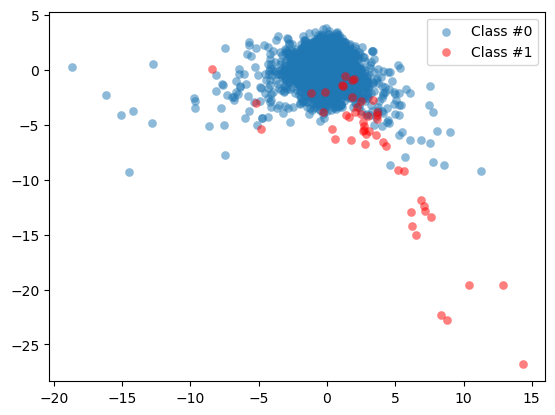

In [13]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

## Resampling our Data

### RandomOverSampler

In [14]:
def compare_plots(X_resampled, y_resampled, X, y):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', edgecolor='k', s=20)
    plt.title('Original Data')
    
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, cmap='winter', edgecolor='k', s=20)
    plt.title('Resampled Data')
    
    plt.show()


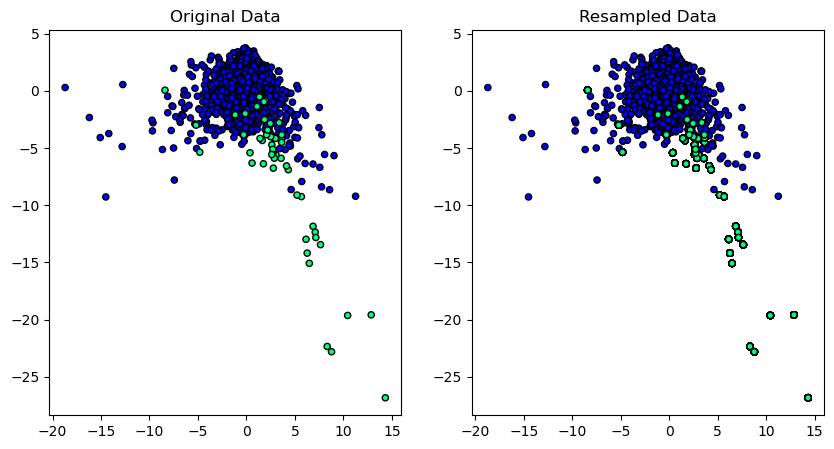

In [15]:
from imblearn.over_sampling import RandomOverSampler

method = RandomOverSampler()
X_resampled, y_resampled = method.fit_resample(X, y)

compare_plots(X_resampled, y_resampled, X, y)


### SMOTE

In [16]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define resampling method and split into train and test
method = BorderlineSMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

# Continue fitting the model and obtain predictions
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Get model performance metrics
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1004
           1       0.75      1.00      0.86         6

    accuracy                           1.00      1010
   macro avg       0.88      1.00      0.93      1010
weighted avg       1.00      1.00      1.00      1010



C:\Users\Asus\anaconda4\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Run the prep_data function
X, y = prep_data(df)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (5050, 28)
y shape: (5050,)


In [18]:
# Define the resampling method
method = SMOTE()

In [19]:
# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

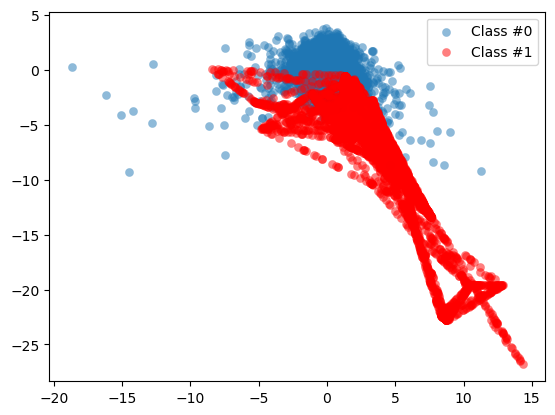

In [20]:
# Plot the resampled data
plot_data(X_resampled, y_resampled)

In [21]:
pd.value_counts(pd.Series(y))

0    5000
1      50
Name: count, dtype: int64

In [22]:
pd.value_counts(pd.Series(y_resampled))

0    5000
1    5000
Name: count, dtype: int64

### Original Versus SMOTE

In [23]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

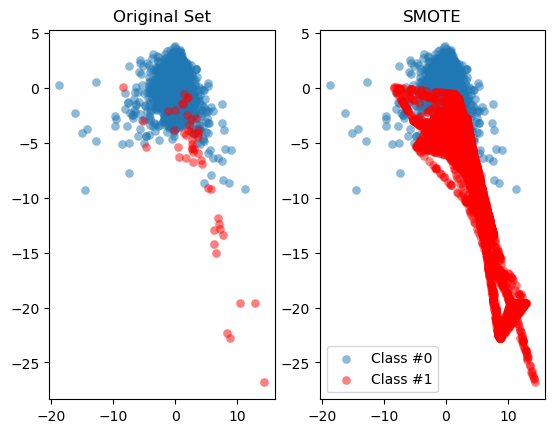

In [24]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

## Fraud Detection Algorithms

In [25]:
# Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
# Model to use
model = LinearRegression()

In [27]:
# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [28]:
# Obtain model predictions from the test data
y_predicted = model.predict(X_test)

In [29]:
# Compare y_test to predictions and obtain performance metrics (r^2 score)
r2_score(y_test, y_predicted)

0.6942744322395706

## Exploring traditional method of fraud detection

In [30]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [31]:
df.groupby('Class').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.035030,0.011553,0.037444,-0.045760,-0.013825,-0.030885,0.014315,-0.022432,-0.002227,0.001667,-0.004511,0.017434,0.004204,0.006542,-0.026640,0.001190,0.004481,-0.010892,-0.016554,-0.002896,-0.010583,-0.010206,-0.003305,-0.000918,-0.002613,-0.004651,-0.009584,0.002414,85.843714
1,-4.985211,3.321539,-7.293909,4.827952,-3.326587,-1.591882,-5.776541,1.395058,-2.537728,-5.917934,4.020563,-7.032865,-0.104179,-7.100399,-0.120265,-4.658854,-7.589219,-2.650436,0.894255,0.194580,0.703182,0.069065,-0.088374,-0.029425,-0.073336,-0.023377,0.380072,0.009304,113.469000


In [32]:
df['flag_as_fraud'] = np.where(np.logical_and(df.V1 < -3, df.V3 < -5), 1, 0)

In [33]:
pd.crosstab(df.flag_as_fraud, df.Class, rownames=['Flagged Fraud'], colnames=['Actual Fraud']) 

# So 22 out of 50 fraud cases where detected

Actual Fraud,0,1
Flagged Fraud,,
0,4984,28
1,16,22


## Ml Classification to detect fraud

In [34]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [35]:
# Fit a logistic regression model to our data
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [36]:
# Obtain model predictions
predicted = model.predict(X_test)

In [37]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1504    1]
 [   2    8]]


## Logistic Regrestion with SMOTE

In [38]:
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [39]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

In [40]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [41]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [42]:
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.59      1.00      0.74        10

    accuracy                           1.00      1515
   macro avg       0.79      1.00      0.87      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1498    7]
 [   0   10]]


## Natural hit rate

In [43]:
X, y = prep_data(df)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (5050, 28)
y shape: (5050,)


In [44]:
X[0, :]

array([-1.01268723e+00, -3.61656463e-01, -1.43161112e+00, -1.09868097e+00,
       -8.42273887e-01, -2.65944111e-02, -3.24086916e-02,  2.15113318e-01,
        1.61895151e+00, -6.54046265e-01, -1.44266462e+00, -1.54653811e+00,
       -2.30008313e-01,  1.78553942e+00,  1.41979301e+00,  7.16655170e-02,
        2.33031136e-01,  2.75911462e-01,  4.14523549e-01,  7.93433622e-01,
        2.88866295e-02,  4.19420877e-01, -3.67528630e-01, -1.55634495e-01,
       -1.57676763e-02,  1.07902703e-02,  1.89000000e+02,  0.00000000e+00])

In [45]:
df.Class.value_counts()

Class
0    5000
1      50
Name: count, dtype: int64

In [46]:
# Count the total number of observations from the length of y
total_obs = len(y)
total_obs

5050

In [47]:
# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
count_non_fraud

5000

In [48]:
percentage = count_non_fraud/total_obs * 100
print(f'{percentage:0.2f}%')

99.01%


## Random Forest Classifier

In [67]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [68]:
# Define the model as the random forest
model = RandomForestClassifier(random_state=5, n_estimators=20)

In [69]:
# Fit the model to our training set
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=5)

In [70]:
# Obtain predictions from the test data 
predicted = model.predict(X_test)

In [71]:
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

Accuracy Score:
0.991


## Performance Evaluation

In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score

# Calculate average precision
average_precision = average_precision_score(y_test, predicted)
print(f"Average Precision: {average_precision:.4f}")

# Obtain precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predicted)

# Obtain model probabilities for the positive class
probs = model.predict_proba(X_test)[:, 1]

# Print ROC_AUC score using probabilities
print(f"ROC AUC Score: {roc_auc_score(y_test, probs):.4f}")


Average Precision: 0.5882
ROC AUC Score: 0.9995


In [51]:
# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

In [52]:
# Predict probabilities
probs = model.predict_proba(X_test)

### ROC

In [53]:
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.999468438538206

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.59      1.00      0.74        10

    accuracy                           1.00      1515
   macro avg       0.79      1.00      0.87      1515
weighted avg       1.00      1.00      1.00      1515


Confusion Matrix:
[[1498    7]
 [   0   10]]


In [81]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)
average_precision

0.7890250388880526

### Precision Recall

In [82]:
# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)
print(f'Precision: {precision}\nRecall: {recall}')

Precision: [0.04155251 0.97333333 1.        ]
Recall: [1.        0.8021978 0.       ]


In [83]:
def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
    return plt.show()

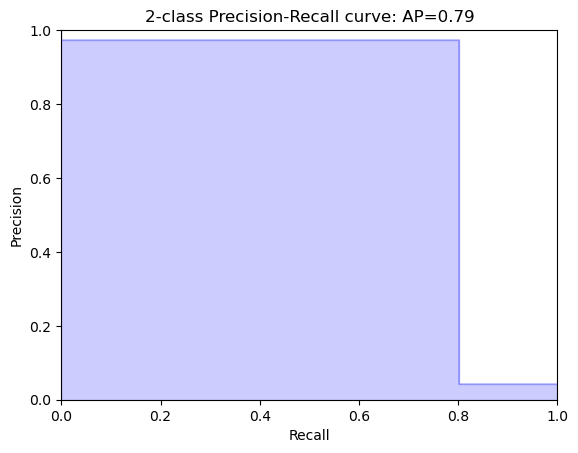

In [84]:
# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

## Fraud detection using unlabeled data

In [54]:
banksim_df = pd.read_csv(banksim_file)
banksim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
banksim_adj_df = pd.read_csv(banksim_adj_file)
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [55]:
banksim_df.shape

(7200, 5)

In [56]:
banksim_df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [57]:
banksim_adj_df.shape

(7189, 18)

In [58]:
banksim_adj_df.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [59]:
banksim_df.groupby(['category'])[['amount', 'fraud']].mean()

,amount,fraud
category,,
es_barsandrestaurants,43.841793,0.022472
es_contents,55.170000,0.000000
es_fashion,59.780769,0.020619
es_food,35.216050,0.000000
es_health,126.604704,0.242798
es_home,120.688317,0.208333
es_hotelservices,172.756245,0.548387
es_hyper,46.788180,0.125000
es_leisure,229.757600,1.000000


In [60]:
banksim_df.groupby(['age'])[['amount', 'fraud']].mean()

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


In [61]:
banksim_df.age.value_counts()

age
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: count, dtype: int64

In [62]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

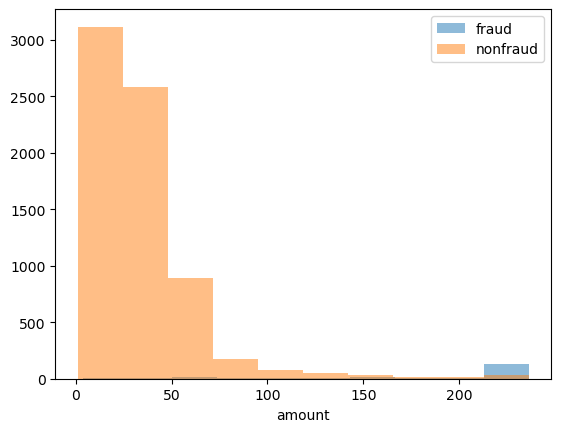

In [63]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

## K Means Clustering

In [64]:
labels = banksim_adj_df.fraud

In [65]:
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [67]:
# Take the float values of df for X
X = banksim_adj_df[cols].values.astype(float)

In [68]:
X.shape

(7189, 17)

## Scaling Data

In [69]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [70]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

In [71]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

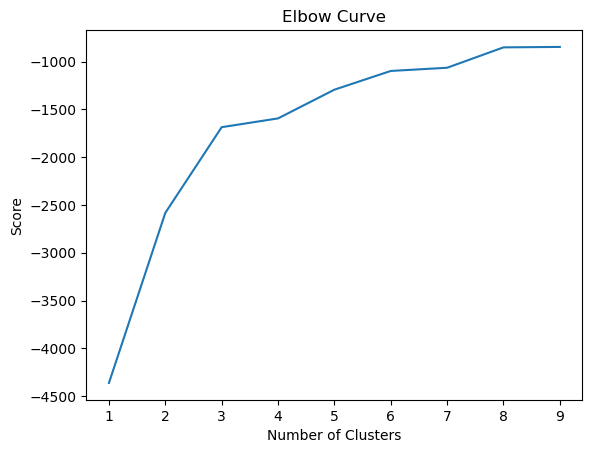

In [72]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### Detecting Outliers

In [79]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0


Confusion matrix, without normalization


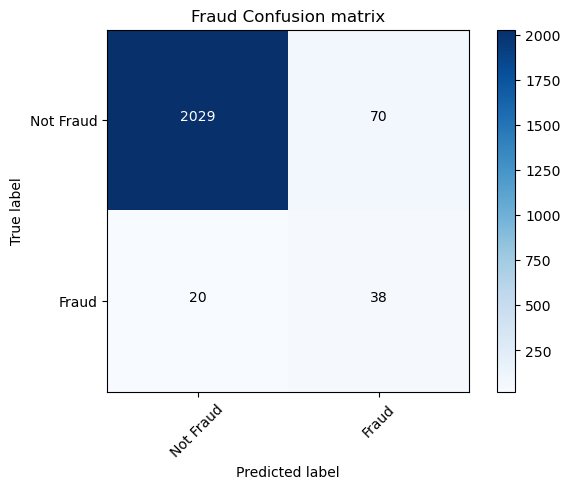

In [80]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

## Text mining to detect fraud

In [83]:
df = pd.read_csv(enron_emails_clean_file)

In [84]:
mask = df['clean_content'].str.contains('sell enron stock', na=False)

In [85]:
# Select the data from df using the mask
df[mask]

,Message-ID,From,To,Date,content,clean_content
154,<6336501.1075841154311.JavaMail.evans@thyme>,('sarah.palmer@enron.com'),('sarah.palmer@enron.com'),2002-02-01 14:53:35,\nJoint Venture: A 1997 Enron Meeting Belies O...,joint venture enron meeting belies officers cl...


In [86]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select from df 
filtered_emails = df[df.clean_content.str.contains('|'.join(searchfor), na=False)]
filtered_emails.head()

,Message-ID,From,To,Date,content,clean_content
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...


In [90]:
# Create flag variable where the emails match the searchfor terms
df['flag'] = np.where((df['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df['flag'].value_counts()
print(count)

flag
0    1776
1     314
Name: count, dtype: int64


## Data Preprocessing

In [109]:
print(df.columns)

Index(['content', 'tokens', 'cleaned_tokens'], dtype='object')


In [108]:
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string

# Ensure NLTK resources are downloaded (if not already done)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # Make sure to download the WordNet resource

# Example DataFrame creation (replace with your actual DataFrame)
data = {'content': ["This is a sample text, demonstrating NLP tokenization, lemmatization, and stemming."]}
df = pd.DataFrame(data)

# Tokenization and immediate processing
df['tokens'] = df['content'].apply(lambda x: [word.lower() for word in word_tokenize(x)])

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Remove stopwords and punctuation
df['cleaned_tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words and not word.isdigit() and word not in punctuation])

# Join tokens back to string to prepare for lemmatization
punc_free = " ".join(df['cleaned_tokens'].iloc[0])  # Example for the first row

# Lemmatize words
lemma = WordNetLemmatizer()
normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())

# Stem words
porter = PorterStemmer()
cleaned_text = " ".join(porter.stem(token) for token in normalized.split())

print(cleaned_text)


sampl text demonstr nlp token lemmat stem


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [110]:
# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to", "cc", "subject", "http", "from", "sent", "ect", "u", "fwd", "www", "com", 'html'))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

In [111]:
# Import the lemmatizer from nltk
lemma = WordNetLemmatizer()

def clean(text, stop):
    text = str(text).rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

In [113]:
# Clean the emails in df and print results
text_clean=[]
for text in df['content']:
    text_clean.append(clean(text, stop).split())    